In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from MakePlots import *
import os
import random
from scipy import stats
from itertools import groupby,combinations
from scipy.optimize import curve_fit
from scipy.stats import t
import statsmodels.api as sm

In [2]:
def quadratic_function(x, a, b, c):
        return a * x**2 + b * x + c

In [ ]:
analysis_dir = Path('/path/to/AnalysisAndFigures-Final')
figure_dir = analysis_dir/'SpecializedPlots'
if not os.path.isdir(figure_dir):
    os.mkdir(figure_dir)

operator_for_average = '75pct'

patient_key = pd.read_excel('/path/to/PatientKey.xlsx')
family1_df = pd.read_csv(analysis_dir/'Rank_Ordered_Barplots'/operator_for_average/f'3.3.0_{operator_for_average}_Family_Clusters_Renamed.tsv',
                        delimiter='\t')

In [4]:
family_key = patient_key[patient_key['Patient#']==3]
proband_ids = family_key[family_key.FigureName.apply(lambda x: 'Proband' in x)]['Sample'].tolist()
carrier_parent = unique(family_key[family_key.FigureName.apply(lambda x: 'Proband' in x)]['CarrierParent'].tolist())[0]
non_carrier_parent = unique(family_key[family_key.FigureName.apply(lambda x: 'Proband' in x)]['NonCarrierParent'].tolist())[0]

In [5]:
relevant_columns = ['plot_allele_id']+[x for x in family1_df.columns if x.split('_')[0] in proband_ids+[carrier_parent,non_carrier_parent]]
proband_df = family1_df[relevant_columns].copy()
proband_df['allele_class'] = 'Uncertain'
carrier_inds=non_carrier_inds=[]
if str(carrier_parent) != 'nan':
    carrier_inds = proband_df[proband_df[f'{carrier_parent}_tvr_consensus'].apply(lambda x: str(x)!='nan')].index
    proband_df.loc[carrier_inds,'allele_class'] = 'Carrier'
if str(non_carrier_parent) != 'nan':
    non_carrier_inds = proband_df[proband_df[f'{non_carrier_parent}_tvr_consensus'].apply(lambda x: str(x)!='nan')].index
    proband_df.loc[non_carrier_inds,'allele_class'] = 'NonCarrier'
shared_inds = [x for x in carrier_inds if x in non_carrier_inds]
proband_df.loc[shared_inds,'allele_class'] = 'Uncertain'

In [6]:
for patient_id in proband_ids+[carrier_parent,non_carrier_parent]:
    proband_df[f'{patient_id}_total_tel_len'] = proband_df.apply(lambda x: get_tel_len_list(x[f'{patient_id}_read_TLs'],True,x[f'{patient_id}_tvr_len']),axis=1)
    proband_df[f'{patient_id}_{operator_for_average}_tel_len'] = proband_df[f'{patient_id}_total_tel_len'].apply(lambda x: find_average(x,operator_for_average))
    proband_df[f'{patient_id}_{operator_for_average}_tel_std_dev'] = proband_df[f'{patient_id}_total_tel_len'].apply(lambda x: np.std(x))

In [7]:
class_dict = {'Carrier':carrier_parent,'NonCarrier':non_carrier_parent}
proband_ro_df = []
for proband_id in proband_ids:
    tdf = proband_df.copy().dropna(subset=f'{proband_id}_tvr_consensus')
    proband_figname = family_key[family_key['Sample']==proband_id]['FigureName'].item()
    for allele_class in ['Carrier','NonCarrier']:
        allele_tdf = tdf[tdf.allele_class==allele_class]
        allele_tdf = allele_tdf.sort_values(by=f'{proband_id}_{operator_for_average}_tel_len')
        allele_tdf['proband_ro'] = [x for x in range(len(allele_tdf))]
        allele_tdf = allele_tdf.sort_values(by=f'{class_dict[allele_class]}_{operator_for_average}_tel_len')
        allele_tdf['parental_ro'] = [x for x in range(len(allele_tdf))]
        allele_tdf.rename(columns={f'{proband_id}_{operator_for_average}_tel_len':'proband_tel_len',
                        f'{class_dict[allele_class]}_{operator_for_average}_tel_len':'parental_tel_len'},inplace=True)
        allele_tdf['proband_id'] = proband_id
        allele_tdf['parental_id'] = class_dict[allele_class]
        allele_tdf['proband_samplename'] = proband_figname
        allele_tdf['parental_samplename'] = family_key[family_key['Sample']==class_dict[allele_class]]['FigureName'].item()
        cols_for_plot = ['allele_class','plot_allele_id'] +[x for x in allele_tdf.columns if 'proband' in x or 'parental' in x]
        allele_tdf = allele_tdf[cols_for_plot].copy()
        proband_ro_df.append(allele_tdf)
proband_ro_df = pd.concat(proband_ro_df)


In [8]:
total_proband_ro_df = []
for proband_id in proband_ids:
    tdf = proband_ro_df[proband_ro_df['proband_id']==proband_id].copy()
    tdf = tdf.sort_values(by='proband_tel_len')
    tdf['total_proband_ro'] = [x for x in range(len(tdf))]
    total_proband_ro_df.append(tdf)
total_proband_ro_df = pd.concat(total_proband_ro_df)

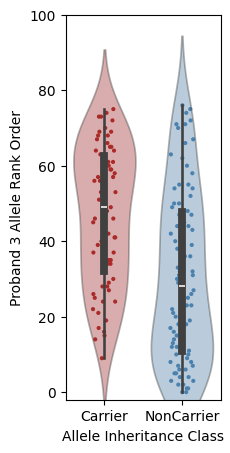

Welch's T-statistic: 4.8541642621225325, P-value: 2.9935264793094595e-06
Median Rank Order for Carrier Alleles: 49.0
Median Rank Order for NonCarrier Alleles: 28.0


In [11]:
file_prefix = 'proband3_ro'
fig,ax = plt.subplots(figsize = (2,5))
total_proband_ro_df = total_proband_ro_df.sort_values(by='allele_class')

i=sns.violinplot(data=total_proband_ro_df,x='allele_class',y='total_proband_ro',hue='allele_class',hue_order=['Carrier','NonCarrier'],
               palette=['firebrick','steelblue'],alpha=0.4,legend=False)
j=sns.stripplot(data=total_proband_ro_df,x='allele_class',y='total_proband_ro',hue='allele_class',hue_order=['Carrier','NonCarrier'],
              dodge=False,jitter=0.15,size=3,palette=['firebrick','steelblue'],zorder=0)

ax.set_xlabel('Allele Inheritance Class')
ax.set_ylabel('Proband 3 Allele Rank Order')
ax.set_ylim(-2,100)

plt.show()
fig.savefig(figure_dir/f'{file_prefix}.png',bbox_inches='tight')
fig.savefig(figure_dir/f'{file_prefix}_transparent.png',bbox_inches='tight',transparent=True)
svg_path = figure_dir/f'{file_prefix}.svg'
ai_path = figure_dir/f'{file_prefix}.ai'
plt.rcParams['svg.fonttype'] = 'none'
# Save the figure as an SVG file
fig.savefig(svg_path, format="svg",bbox_inches='tight')
# Convert the SVG file to AI format
cairosvg.svg2pdf(url=str(svg_path), write_to=str(ai_path))
plt.close()

group1 = total_proband_ro_df[total_proband_ro_df['allele_class']=='Carrier']['total_proband_ro'].tolist()
group2 = total_proband_ro_df[total_proband_ro_df['allele_class']=='NonCarrier']['total_proband_ro'].tolist()
t_statistic_welch, p_value_welch = stats.ttest_ind(group1, group2, equal_var=False)
print(f"Welch's T-statistic: {t_statistic_welch}, P-value: {p_value_welch}")
with open(figure_dir/f'{file_prefix}_ttest_stats.txt','w') as f:
    f.write(f"Welch's T-statistic: {t_statistic_welch}, P-value: {p_value_welch}")
    for allele_class in ['Carrier','NonCarrier']:
        median_stat = total_proband_ro_df[total_proband_ro_df['allele_class']==allele_class]['total_proband_ro'].median()
        print(f'Median Rank Order for {allele_class} Alleles: {median_stat}')
        f.write(f'Median Rank Order for in {allele_class} Alleles: {median_stat}\n')

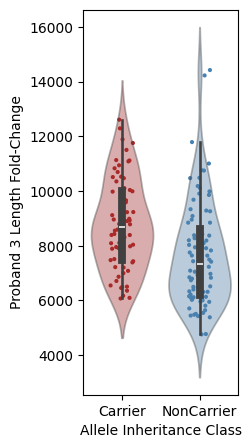

Welch's T-statistic: 3.803438017916556, P-value: 0.00020767645325152654
Median Tel Length for Carrier Alleles: 8671.5
Median Tel Length for NonCarrier Alleles: 7324.875


In [ ]:
file_prefix = 'proband3_tel_len'
fig,ax = plt.subplots(figsize = (2,5))

i=sns.violinplot(data=total_proband_ro_df,x='allele_class',y='proband_tel_len',hue='allele_class',hue_order=['Carrier','NonCarrier'],
               palette=['firebrick','steelblue'],alpha=0.4,legend=False)
j=sns.stripplot(data=total_proband_ro_df,x='allele_class',y='proband_tel_len',hue='allele_class',hue_order=['Carrier','NonCarrier'],
              dodge=False,jitter=0.15,size=3,palette=['firebrick','steelblue'],zorder=0)

ax.set_xlabel('Allele Inheritance Class')
ax.set_ylabel('Proband 3 Telomere Length')

plt.show()
fig.savefig(figure_dir/f'{file_prefix}.png',bbox_inches='tight')
fig.savefig(figure_dir/f'{file_prefix}_transparent.png',bbox_inches='tight',transparent=True)
svg_path = figure_dir/f'{file_prefix}.svg'
ai_path = figure_dir/f'{file_prefix}.ai'
plt.rcParams['svg.fonttype'] = 'none'
# Save the figure as an SVG file
fig.savefig(svg_path, format="svg",bbox_inches='tight')
# Convert the SVG file to AI format
cairosvg.svg2pdf(url=str(svg_path), write_to=str(ai_path))
plt.close()

group1 = total_proband_ro_df[total_proband_ro_df['allele_class']=='Carrier']['proband_tel_len'].tolist()
group2 = total_proband_ro_df[total_proband_ro_df['allele_class']=='NonCarrier']['proband_tel_len'].tolist()
t_statistic_welch, p_value_welch = stats.ttest_ind(group1, group2, equal_var=False)
print(f"Welch's T-statistic: {t_statistic_welch}, P-value: {p_value_welch}")
with open(figure_dir/f'{file_prefix}_ttest_stats.txt','w') as f:
    f.write(f"Welch's T-statistic: {t_statistic_welch}, P-value: {p_value_welch}")
    for allele_class in ['Carrier','NonCarrier']:
        median_stat = proband_ro_df[proband_ro_df['allele_class']==allele_class]['proband_tel_len'].median()
        print(f'Median Tel Length for {allele_class} Alleles: {median_stat}')
        f.write(f'Median Tel Length for in {allele_class} Alleles: {median_stat}\n')

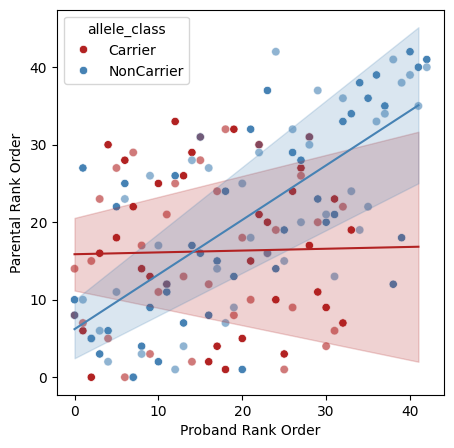

In [19]:
file_prefix = 'fam3_proband_parental_RO_fit'
with open(figure_dir/f'{file_prefix}_regression_stats.txt', 'w') as f:
    pass
fig,ax = plt.subplots(figsize = (5,5))
alpha_value = 1
for proband_id in proband_ids:
    include_legend = True
    if alpha_value<1:
        include_legend=False
    i=sns.scatterplot(data=proband_ro_df[proband_ro_df['proband_id']==proband_id],x='proband_ro',y='parental_ro',hue='allele_class',alpha=alpha_value,
                      hue_order=['Carrier','NonCarrier'],palette=['firebrick','steelblue'],legend=include_legend)
    alpha_value-=0.4

colors_dict = {'Carrier':'firebrick','NonCarrier':'steelblue'}
x_line = [x for x in range(min(proband_ro_df.proband_ro.tolist()),max(proband_ro_df.proband_ro.tolist()))]
for allele_class in ['Carrier','NonCarrier']:
    allele_ro_df = proband_ro_df[proband_ro_df.allele_class==allele_class]
    x_data = allele_ro_df.proband_ro.tolist()
    y_data = allele_ro_df.parental_ro.tolist()
    # Fit OLS model with intercept
    const_x = sm.add_constant(x_data, prepend=False)
    model = sm.OLS(y_data, const_x)
    results = model.fit()
    params = results.params
    ax.plot(x_line, [x * params[0] + params[1] for x in x_line],color=colors_dict[allele_class])

    with open(figure_dir/f'{file_prefix}_regression_stats.txt', 'a') as f:
        f.write(f'Regression Stats for {allele_class} Alleles:\n')
        f.write(results.summary().as_text())
        f.write('\n\n'+'='*78+'\n'+'='*78+'\n\n')
    
    confidence_intervals = results.conf_int(alpha=0.05)
    lower_bounds = [x * confidence_intervals[0,0] + confidence_intervals[1,0] for x in x_line]
    upper_bounds = [x * confidence_intervals[0,1] + confidence_intervals[1,1] for x in x_line]
    k = plt.fill_between(x_line,lower_bounds,upper_bounds,color=colors_dict[allele_class],alpha=0.2)
ax.set_xlabel('Proband Rank Order')
ax.set_ylabel('Parental Rank Order')
plt.show()
fig.savefig(figure_dir/f'{file_prefix}.png',bbox_inches='tight')
fig.savefig(figure_dir/f'{file_prefix}_transparent.png',bbox_inches='tight',transparent=True)
svg_path = figure_dir/f'{file_prefix}.svg'
ai_path = figure_dir/f'{file_prefix}.ai'
plt.rcParams['svg.fonttype'] = 'none'
# Save the figure as an SVG file
fig.savefig(svg_path, format="svg",bbox_inches='tight')
# Convert the SVG file to AI format
cairosvg.svg2pdf(url=str(svg_path), write_to=str(ai_path))
plt.close()
    

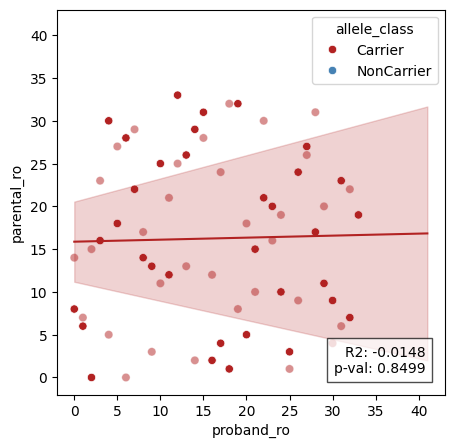

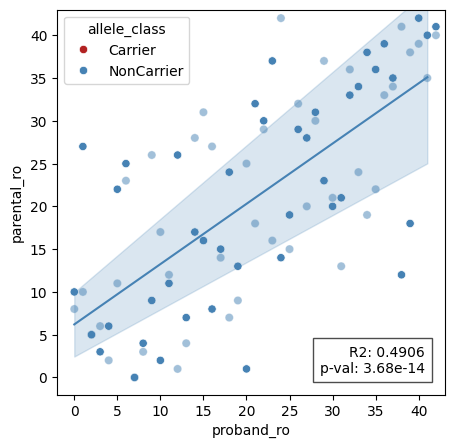

In [25]:
base_file_prefix = 'fam3_proband_parental_RO_split'
with open(figure_dir/f'{base_file_prefix}_regression_stats.txt', 'w') as f:
    pass
x_line = [x for x in range(min(proband_ro_df.proband_ro.tolist()),max(proband_ro_df.proband_ro.tolist()))]
colors_dict = {'Carrier':'firebrick','NonCarrier':'steelblue'}

for allele_class in ['Carrier','NonCarrier']:
    fig,ax = plt.subplots(figsize = (5,5))
    alpha_value = 1
    allele_ro_df = proband_ro_df[proband_ro_df.allele_class==allele_class]
    for proband_id in proband_ids:
        include_legend = True
        if alpha_value<1:
            include_legend=False
        i=sns.scatterplot(data=allele_ro_df[allele_ro_df['proband_id']==proband_id],x='proband_ro',y='parental_ro',hue='allele_class',alpha=alpha_value,
                        hue_order=['Carrier','NonCarrier'],palette=['firebrick','steelblue'],legend=include_legend)
        alpha_value-=0.5

    x_data = allele_ro_df.proband_ro.tolist()
    y_data = allele_ro_df.parental_ro.tolist()
    # Fit OLS model with intercept
    const_x = sm.add_constant(x_data, prepend=False)
    model = sm.OLS(y_data, const_x)
    results = model.fit()
    params = results.params
    ax.plot(x_line, [x * params[0] + params[1] for x in x_line],color=colors_dict[allele_class])
    file_prefix = f'{base_file_prefix}_{allele_class.lower()}'
    with open(figure_dir/f'{base_file_prefix}_regression_stats.txt', 'a') as f:
        f.write(f'Regression Stats for {allele_class} Alleles:\n')
        f.write(results.summary().as_text())
        f.write('\n\n'+'='*78+'\n'+'='*78+'\n\n')
    p_value = results.f_pvalue
    if p_value <0.01:
        p_value = "{:.2e}".format(p_value)
    else:
        p_value = round(p_value,4)
    text_content = f"R2: {round(results.rsquared_adj,4)}\np-val: {p_value}"
    ax.text(0.95, 0.05, text_content, transform=ax.transAxes, ha='right', va='bottom',
            bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 5})
    
    confidence_intervals = results.conf_int(alpha=0.05)
    lower_bounds = [x * confidence_intervals[0,0] + confidence_intervals[1,0] for x in x_line]
    upper_bounds = [x * confidence_intervals[0,1] + confidence_intervals[1,1] for x in x_line]
    k = plt.fill_between(x_line,lower_bounds,upper_bounds,color=colors_dict[allele_class],alpha=0.2)
    ax.set_xlim(min(x_line)-2,max(x_line)+2)
    ax.set_ylim(min(x_line)-2,max(x_line)+2)
    plt.show()
    ax.set_xlabel('Proband Rank Order')
    ax.set_ylabel('Parental Rank Order')
    plt.show()

    fig.savefig(figure_dir/f'{file_prefix}.png',bbox_inches='tight')
    fig.savefig(figure_dir/f'{file_prefix}_transparent.png',bbox_inches='tight',transparent=True)
    svg_path = figure_dir/f'{file_prefix}.svg'
    ai_path = figure_dir/f'{file_prefix}.ai'
    plt.rcParams['svg.fonttype'] = 'none'
    # Save the figure as an SVG file
    fig.savefig(svg_path, format="svg",bbox_inches='tight')
    # Convert the SVG file to AI format
    cairosvg.svg2pdf(url=str(svg_path), write_to=str(ai_path))
    plt.close()